# Imports

In [1]:
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load data
Each numpy array with dimension [images, X points, Y points, channel]
* Pressure 8x8
* Velocity groun truth 16x64
* Binary mask 16x64
* Vibrational frequencies
* Number of vibrational modes
* Coordinate of x,y violin dimensions

In [2]:
# load pressure image 8x8
with open("IN_pressure", 'rb') as data:
  X_pressure = pickle.load(data)

# load velocity ground truth image 16x64
with open("GT_velocity", 'rb') as data:
  GT_velocity = pickle.load(data)

# load binary mask 16x64
with open("binary_mask", 'rb') as data:
  binary_mask = pickle.load(data)

# load vibrational frequencies
with open("frequency", 'rb') as data:
  freq = pickle.load(data)

# load vibrational mode numbers
with open("mode_numbers", 'rb') as data:
  mode = pickle.load(data)

# load violin dimensions [cm]
with open("Lx_dimension", 'rb') as data:
  Lx_dimension = pickle.load(data)
with open("Ly_dimension", 'rb') as data:
  Ly_dimension = pickle.load(data)

Display data

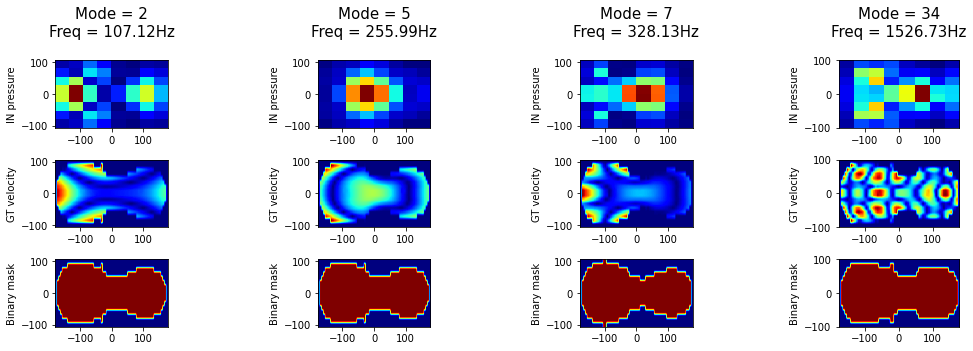

In [3]:
n = X_pressure.shape[0]
plt.figure(figsize=(15, 5))
for i in range(n):

  description = "Mode = " + str(mode[i]) + "\nFreq = " + str(freq[i]) + "Hz\n"

  # display input pressure
  ax1 = plt.subplot(3, n, i+1)
  plt.imshow(X_pressure[i].reshape(8, 8), extent=(-Lx_dimension[i]/2, Lx_dimension[i]/2, -Ly_dimension[i]/2, Ly_dimension[i]/2), aspect='auto')
  ax1.set_aspect('equal')
  plt.ylabel("IN pressure")
  plt.jet()

  # display ground truth velocity
  ax2 = plt.subplot(3, n, i+1 + n, sharex=ax1)
  plt.imshow(GT_velocity[i].reshape(16, 64), extent=(-Lx_dimension[i]/2, Lx_dimension[i]/2, -Ly_dimension[i]/2, Ly_dimension[i]/2), aspect='auto')
  ax2.set_aspect('equal')
  plt.jet()
  plt.ylabel("GT velocity")

  # display binary mask
  ax3 = plt.subplot(3, n, i+1 + n*2, sharex=ax1)
  plt.imshow(binary_mask[i].reshape(16, 64), extent=(-Lx_dimension[i]/2, Lx_dimension[i]/2, -Ly_dimension[i]/2, Ly_dimension[i]/2), aspect='auto')
  ax3.set_aspect('equal')
  plt.jet()
  plt.ylabel("Binary mask")

  ax1.text(0.5,1.1, description, size=15, ha="center", transform=ax1.transAxes)
    
plt.tight_layout()
plt.show()

# Metrics definition

Normalized Cross Correlation [in 0,1]

In [4]:
def nccMetric(out, gt):
  ''' 
    out: ndarray estimates
    gt: ndarray ground truth
    returns: normalized cross correlation
  '''
  ncc = np.zeros(shape = (gt.shape[0]))
  
  # foreach images
  for i in range(len(ncc)):
    numerator = np.sum(out[i].reshape(16,64) * gt[i].reshape(16,64))
    a = np.sqrt(np.sum(np.power(out[i].reshape(16,64), 2)))
    b = np.sqrt(np.sum(np.power(gt[i].reshape(16,64), 2)))
    denominator = a * b
    ncc[i] = numerator/denominator

  return np.asarray(ncc)

Normalized Mean Square Error [in dB]

In [5]:
def nmseMetric(out, gt):
  ''' 
    out: ndarray estimates
    gt: ndarray ground truth
    returns: normalized mean square error in dB
  '''
  nmse = np.zeros(shape = (out.shape[0]))

  # foreach images
  for i in range(len(nmse)):
    prediction_img = out[i].reshape(16,64)
    groundtruth_img = gt[i].reshape(16,64)

    numerator = mean_squared_error(prediction_img, groundtruth_img)
    denominator = mean_squared_error(groundtruth_img, np.zeros(groundtruth_img.shape))

    nmse[i] = 10*np.log10(numerator/denominator)
  return np.asarray(nmse)

# Noiseless validation

## Load model & weights

In [6]:
model = keras.models.load_model("model_weights_64.h5", compile=True)
#model.summary()

## Test

Prediction

In [7]:
out_srcnn = model.predict([X_pressure, binary_mask])

Metrics evaluation

In [8]:
ncc = nccMetric(out_srcnn, GT_velocity)
nmse = nmseMetric(out_srcnn, GT_velocity)

print("NCC = ", ncc)
print("NMSE(dB) = ", nmse)

NCC =  [0.99659464 0.99647625 0.99217572 0.9479193 ]
NMSE(dB) =  [-21.44451827 -21.10940253 -14.77590718  -9.36081906]


View output

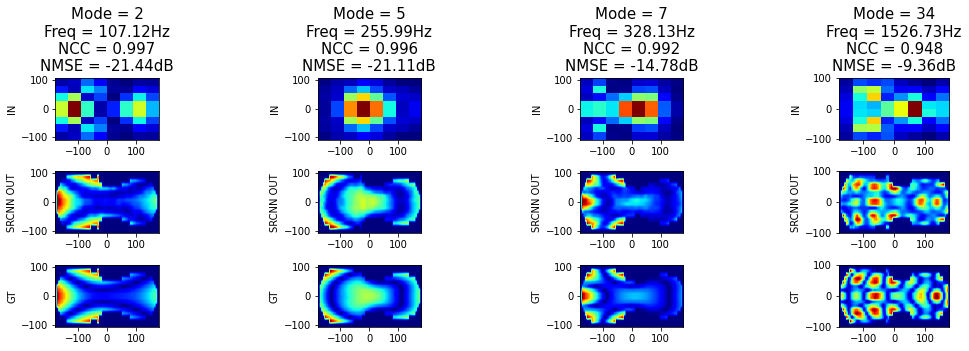

In [9]:
n = X_pressure.shape[0]
plt.figure(figsize=(15, 5))
for i in range(n):

  description = "Mode = " + str(mode[i]) + "\nFreq = " + str(freq[i]) + "Hz"
  description = description + "\nNCC = " + str(round(ncc[i], 3)) + "\nNMSE = " + str(round(nmse[i], 2)) + "dB"

  # display input pressure
  ax1 = plt.subplot(3, n, i+1)
  plt.imshow(X_pressure[i].reshape(8, 8), extent=(-Lx_dimension[i]/2, Lx_dimension[i]/2, -Ly_dimension[i]/2, Ly_dimension[i]/2), aspect='auto')
  ax1.set_aspect('equal')
  plt.ylabel("IN")
  plt.jet()

  # display ground truth velocity
  ax2 = plt.subplot(3, n, i+1 + n, sharex=ax1)
  plt.imshow(out_srcnn[i].reshape(16, 64), extent=(-Lx_dimension[i]/2, Lx_dimension[i]/2, -Ly_dimension[i]/2, Ly_dimension[i]/2), aspect='auto')
  ax2.set_aspect('equal')
  plt.jet()
  plt.ylabel("SRCNN OUT")

  # display binary mask
  ax3 = plt.subplot(3, n, i+1 + n*2, sharex=ax1)
  plt.imshow(GT_velocity[i].reshape(16, 64), extent=(-Lx_dimension[i]/2, Lx_dimension[i]/2, -Ly_dimension[i]/2, Ly_dimension[i]/2), aspect='auto')
  ax3.set_aspect('equal')
  plt.jet()
  plt.ylabel("GT")

  ax1.text(0.5,1.1, description, size=15, ha="center", transform=ax1.transAxes)
    
plt.tight_layout()
plt.show()